<IPython.core.display.Javascript object>


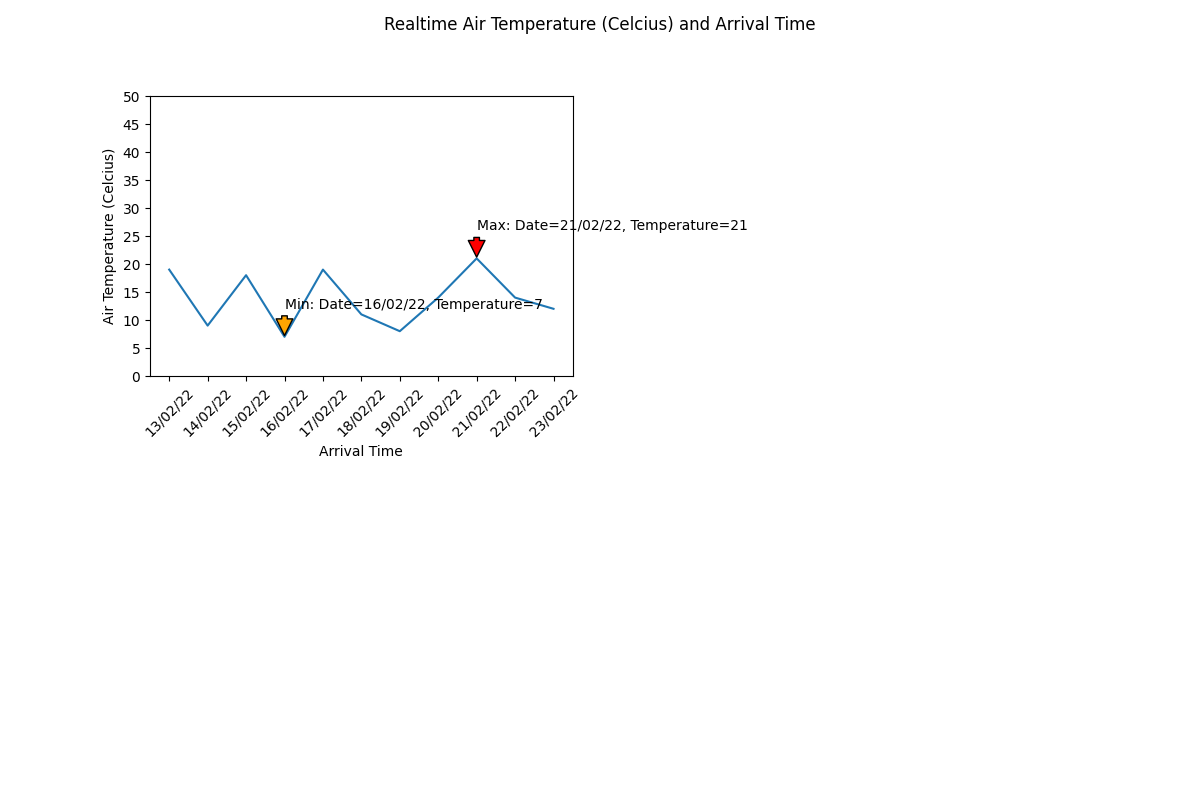

In [1]:
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import ast
import json

%matplotlib notebook

topic = 'Assignment'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Date={}, Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Date={}, Temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
        _consumer = KafkaConsumer(
            topic,
            consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
            # comment this if you don't want to consume earliest available message
            auto_offset_reset='earliest',
            bootstrap_servers=['localhost:9092'],
            api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plot():
    try:
        width = 12
        height = 8

        # Initialise plot
        fig = plt.figure(figsize=(width, height))
        fig.suptitle(
            'Realtime Air Temperature (Celcius) and Arrival Time')

        # Create axis for plot
        ax = fig.add_subplot(221)
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature (Celcius)')
        ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
        ax.set_ylim(0, 50)

        # Draw plot
        fig.show()
        fig.canvas.draw()

        return fig, ax

    except Exception as ex:
        print(str(ex))


def consume_messages(consumer, fig, asx):
    try:
        # container for x and y values
        x, y = [], []
        # For each message from the incomming stream.
        for data in consumer:
            my_bytes = data.value
            my_json = my_bytes.decode("utf8").replace("'", '"')
            message = json.loads(my_json)
            if message["sender_id"] == "climate_producer":
                # print(message)

                message_date = dt.datetime.fromisoformat(message['created_date']) # Clean the date from ISO to dd/mm/yy
                clean_date = message_date.strftime('%-d/%m/%y')

                x.append(clean_date) # Append x & y values to arrays
                y.append(message['air_temperature_celcius'])

            # Start plotting when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y) # Plot all x & y values.
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature (Celcius)')
                ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
                ax.set_ylim(0, 50)
                # Rotate dates to make them clear to see.
                ax.tick_params(axis='x', labelrotation=45) 

                annotate_max(x,y)
                annotate_min(x,y)

                fig.canvas.draw()
                
                # removing the item in the first position
                x.pop(0)
                y.pop(0)

        plt.close('all')
    except Exception as ex:
        print(str(ex))


if __name__ == '__main__':

    consumer = connect_kafka_consumer()
    fig, ax = init_plot()
    consume_messages(consumer, fig, ax)

<IPython.core.display.Javascript object>


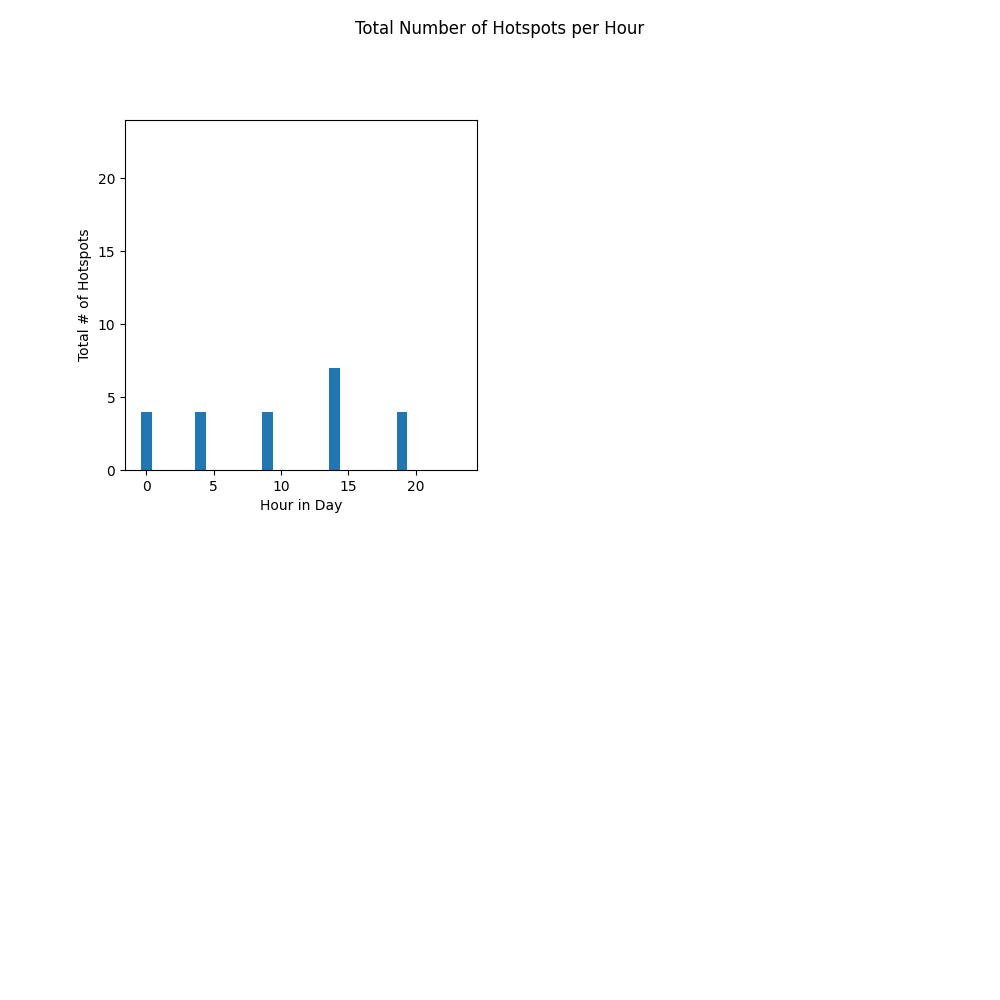

In [2]:
import pymongo
import matplotlib.pyplot as plt
import datetime as dt
from pprint import pprint

# Required for Jupyter inline display
%matplotlib notebook

client = pymongo.MongoClient()
db = client.fit3182_db
collection = db.hotspot

# Collect all hotspots from the database
result = collection.find({})

# Create a bucket array for each hour of the day.
hour_data = [[0] for x in range(24)]

# For each time, increment count in relative hour bucket.
for x in result:
    hour_date =  (dt.datetime.strptime(x['time'], '%H:%M:%S'))
    hour =  int(hour_date.strftime('%H'))
    count = hour_data[hour][0] + 1
    hour_data[hour][0] = count
    
x, y = [], []

# Add each hour count & hour the relative x & y axis for easy plotting.
for i in range(0, len(hour_data)):
    y.append(hour_data[i][0])
    x.append(i)

width = 10
height = 10

# Plot bar chart.
fig = plt.figure(figsize=(width, height))
fig.suptitle('Total Number of Hotspots per Hour')
ax = fig.add_subplot(221)
ax.bar(x, y)
ax.set_xlabel('Hour in Day')
ax.set_ylabel('Total # of Hotspots')
ax.set_ylim(0, 24)

fig.show()
fig.canvas.draw()

In [3]:
import folium
import pymongo
from pymongo import MongoClient

def map_plot():
    # Initial location Melbourne
    m = folium.Map(location=[-38.043995, 145.264296], zoom_start=7)

    client = pymongo.MongoClient()
    db = client.fit3182_db
    climate_collection = db.climate # collection named "climate"
    hotspot_collection = db.hotspot # collection names "hotspot"

    result = db.climate.aggregate([
    {
    "$lookup":{
        "from": "hotspot",
        "localField": 'created_date',
        "foreignField": 'created_date',
        "as":"hotspots",
        }
    },
    {
    "$project" : {"created_date":1,"air_temperature_celcius":1,"relative_humidity":1,"max_wind_speed":1,"hotspots":{"surface_temperature_celcius":1,"cause":1,"latitude":1,"longitude":1
    }}}
    ])

    # For each hotspot
    for each in result:
        if len(each['hotspots']) > 0:
        #data for pop-up information.
            cause = each['hotspots'][0]['cause']
            latitude = each['hotspots'][0]['latitude']
            longitude = each['hotspots'][0]['longitude']
            surface_temperature = each['hotspots'][0]['surface_temperature_celcius']
            air_temperature = each['air_temperature_celcius']
            relative_humidity = each['relative_humidity']

    #pop-up information
            information = "<b>Cause:</b> %s</br><b>Surface Temperature:</b> %d</br><b>Air Temperature:</b> %d</br><b>Relative Humidity:</b> %d" % (
            cause, surface_temperature, air_temperature, relative_humidity)

        # If naturual, add blue marker, else use red.
            if cause == 'natural':
                folium.Marker(
                location=[latitude, longitude],
                popup=folium.Popup(html=information, max_width='100%'),
                icon=folium.Icon(color="blue", icon="info-sign"),
                ).add_to(m)
            else:
                folium.Marker(
                location=[latitude, longitude],
                popup=folium.Popup(html=information, max_width='100%'),
                icon=folium.Icon(color="red", icon="info-sign"),
                ).add_to(m)
    
    return m

if __name__ == "__main__":
    
    # Step 1. Access to the database and read the record using find()
    client = MongoClient()
    db = client.fit3182_db
    
    # Step 2. To get map object with markers
    plot_map = map_plot()
    
    # Step 3. To plot map object
    display(plot_map)